this is the start orientation (0.0, 0.0, 0.0, 1.0)
3.0
((-2.0, 1.0, 0.0), (0.0, 0.0, 0.0, 1.0))
(0.0, 0.0, 0.0, 1.0) this is the quaternion of 90 degress
2.8284271247461903 m
control angle:  1.413716694115407
alpha 0.0
beta 0.3827
angle:  (0.0, -0.0, 0.0)
error in x =  2.0 m
error in y =  2.0 m
taking left
distance:  2.8284271247461903 m
posx -2.0
posy 1.0
control angle:  1.1780972450961724
target_velocity of wheels:  2.01168
target_angle:  1.1780972450961724
linear_velocity:  0.0


reward for left
local_reward :  10
0.0 m/s
REWARD:  10
2.8279392802776635 m
control angle:  1.1784077866329383
alpha -0.0
beta 0.3828
angle:  (2.1359147973257734e-08, -1.2004312443361018e-06, -7.319393366372413e-09)
error in x =  1.99931002547205 m
error in y =  1.999999998746075 m
taking left
distance:  2.8279392802776635 m
posx -1.99931002547205
posy 1.000000001253925
control angle:  1.178356029710144
target_velocity of wheels:  1.6480449329617048
target_angle:  1.178356029710144
linear_velocity:  0.08280

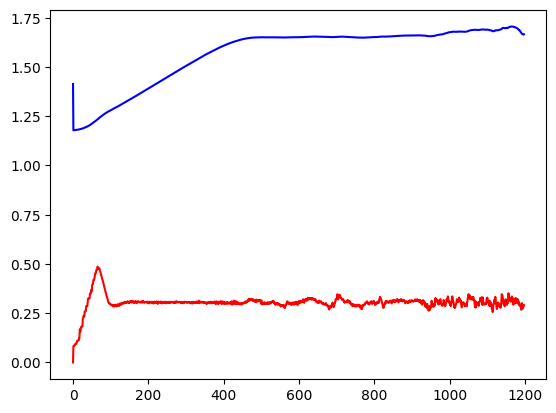

In [25]:
import pybullet as p
import numpy as np
import pybullet_data
import time
from math import floor
import matplotlib.pyplot as plt
pi = np.pi
error = 0 # reference_velocity - actual_velocity
reference_velocity = 0.3048
actual_velocity = 0
e_old=0
e_new=0
E_old = 0 # this is the summation of errors
E_new = 0#this is also the summation of errors
Kp=6 #very importtant
Ki=0.3
Kd=0.3
time_step = 1./240.
u_t = Kp*error + Kd*((e_new - e_old)/time_step) + Ki*(time_step)*(E_new)
def find_distance_origin(x,y): #R8
    return np.sqrt(x*x + y*y)
def find_distance(x1,y1,x2,y2) ->int: 
    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return format(distance, f".{global_position_precision}f")
def turn(robotId,error,finalPos): # only for 90 degree inplace turns
    i=2
    global flag
    flag=1
    #while(float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f")) <= 0.707):
    print("----------this should be the turn",p.getQuaternionFromEuler([0,0,np.arctan(finalPos[1]/finalPos[0])]))
    value = p.getQuaternionFromEuler([0,0,np.arctan(finalPos[1]/finalPos[0])])
    while(float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f")) <= value[2]):
        target_velocity = velocity_controller(error)
        p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=0,controlMode=p.VELOCITY_CONTROL,targetVelocity = -10 ,force = maxForce)
        p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=1,controlMode=p.VELOCITY_CONTROL,targetVelocity = -10,force = maxForce)
        p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=2,controlMode=p.VELOCITY_CONTROL,targetVelocity = +10,force = maxForce)
        p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=3,controlMode=p.VELOCITY_CONTROL,targetVelocity = +10,force = maxForce)
        #print(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
        p.stepSimulation()
        time.sleep(1./240.)
        
        
def velocity_controller(error):
    global e_old
    global E_new
    e_dot = (error - e_old) #the Kd part of the constant covers the delta_t or the time step part too.
    E_new = E_new + error #this the summation of all the errors, and is used in the integtal part of u_t (del t is part of Ki)
    u = Kp*error + Kd*e_dot + Ki*E_new
    e_old = error
    return u #the final velocity


Kpw = 1.5 #very important for refernce with 6
Kiw = 0
Kdw = 0.3
#this is where the robot should stop.
w_old = 0
W_new = 0
def angular_controller(error):
    global w_old
    global W_new
    w_dot = (error - w_old) #the Kd part of the constant covers the delta_t or the time step part too.
    W_new = W_new + error #this the summation of all the errors, and is used in the integtal part of u_t (del t is part of Ki)
    w = Kpw*error + Kdw*w_dot + Kiw*W_new
    w_old = error
    print("control angle: ",w)
    return w #the final angular velocity 
left_flag = 0
right_flag = 1
straight_flag = 2
total_reward = 0


def reward_func(action,alpha,beta,error_in_distance):
        reward = 0
        angle_error = beta - alpha 
        if angle_error > 0:
            #go left
            if action == 0:
                reward = reward + 10
                print("reward for left")
        elif angle_error < 0:
            # go right
            if action ==1:
                reward = reward + 10
                print("reward for right")
        else:
            #go straight
            if action == 2:
                reward = reward + 10
                print("reward for straight")
        if error_in_distance < np.sqrt((startPos[0]-finalPos[0])**2 + (startPos[1]-finalPos[1])**2):
                reward = reward + (1/(error_in_distance + 0.999))*10
                print("reward for min dis")
        if error_in_distance > np.sqrt((startPos[0]-finalPos[0])**2 + (startPos[1]-finalPos[1])**2):
            reward = reward - (error_in_distance)*10
            print("negative for maximizing dis")
        if error_in_distance < 0.2:
            reward = reward + 200
            print("reward for reaching point",error_in_distance)
        print("local_reward : ",reward)
        return reward
    
def left(robotId,error_in_velocity,finalPos):
         #turn left from where it is facing
                    info = 0
                    terminate = 0
                    truncate = 0
                    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
                    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    if beta < 0:
                        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))           
                    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                    linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                    linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                    print("alpha",alpha)
                    print("beta",beta)
                    print("angle: ",p.getEulerFromQuaternion(p.getBasePositionAndOrientation(robotId)[1]))
                    print("error in x = ",error_in_x,"m")
                    print("error in y = ",error_in_y,"m")
                    print("taking left")
                    print("distance: ",error_in_distance,"m")
                    posx = p.getBasePositionAndOrientation(robotId)[0][0]
                    posy = p.getBasePositionAndOrientation(robotId)[0][1]
                    print("posx",p.getBasePositionAndOrientation(robotId)[0][0])
                    print("posy",p.getBasePositionAndOrientation(robotId)[0][1])
                    error_in_angle = np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))
                    #error_in_angle = reference_angle - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))
                    target_velocity = velocity_controller(error_in_velocity)
                    target_angle = angular_controller(error_in_angle)
                    print("target_velocity of wheels: ",target_velocity)
                    print("target_angle: ",target_angle)
                    print("linear_velocity: ",linear_velocity)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=0,controlMode=p.VELOCITY_CONTROL,targetVelocity = -(target_velocity + 0.3048*0.5*target_angle)/0.04 ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=2,controlMode=p.VELOCITY_CONTROL,targetVelocity = -((target_velocity - 0.3048*0.5*target_angle)/0.04) ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=1,controlMode=p.VELOCITY_CONTROL,targetVelocity = -(target_velocity + 0.3048*0.5*target_angle)/0.04 ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=3,controlMode=p.VELOCITY_CONTROL,targetVelocity = -((target_velocity - 0.3048*0.5*target_angle)/0.04) ,force = maxForce)
                    p.stepSimulation()
                    time.sleep(1./50.)
                    print("\n")
                    reward = reward_func(0,alpha,beta,error_in_distance)
                    
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                    linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                    linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    if beta < 0:
                        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))           
                    posx = p.getBasePositionAndOrientation(robotId)[0][0]
                    posy = p.getBasePositionAndOrientation(robotId)[0][1]
                    
                    
                    return [alpha,beta,error_in_distance,linear_velocity,posx,posy],reward,terminate,truncate,info
                
def right(robotId,error_in_velocity,finalPos):
                    info = 1
                    terminate = 0
                    truncate = 0
                    
                    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
                    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    if beta < 0:
                        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    print("alpha",alpha)
                    print("beta",beta)
                    print("angle: ",p.getEulerFromQuaternion(p.getBasePositionAndOrientation(robotId)[1]))
                    
                    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
                    #error_in_angle = reference_angle - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_angle = np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))
                    target_angle = angular_controller(error_in_angle)
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                    linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                    linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                    posx = p.getBasePositionAndOrientation(robotId)[0][0]
                    posy = p.getBasePositionAndOrientation(robotId)[0][1]
                    print("error in x = ",error_in_x,"m")
                    print("error in y = ",error_in_y,"m")
                    print("posx",p.getBasePositionAndOrientation(robotId)[0][0])
                    print("posy",p.getBasePositionAndOrientation(robotId)[0][1])
                    print("taking right")
                    target_velocity = velocity_controller(error_in_velocity)
                    print("distance: ",error_in_distance,"m")
                    print("target_velocity of wheels: ",target_velocity)
                    print("target_angle: ",target_angle)
                    print("linear_velocity: ",linear_velocity)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=0,controlMode=p.VELOCITY_CONTROL,targetVelocity = -((target_velocity - 0.3048*0.5*(target_angle))/0.04) ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=2,controlMode=p.VELOCITY_CONTROL,targetVelocity = -((target_velocity + 0.3048*0.5*(target_angle))/0.04) ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=1,controlMode=p.VELOCITY_CONTROL,targetVelocity = -((target_velocity - 0.3048*0.5*target_angle)/0.04) ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=3,controlMode=p.VELOCITY_CONTROL,targetVelocity = -((target_velocity + 0.3048*0.5*(target_angle))/0.04) ,force = maxForce)
                    
                    p.stepSimulation()
                    time.sleep(1./50.)
                    print("\n")
                    reward = reward_func(1,alpha,beta,error_in_distance)
                    
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                    linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                    linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    if beta < 0:
                        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))           
                    posx = p.getBasePositionAndOrientation(robotId)[0][0]
                    posy = p.getBasePositionAndOrientation(robotId)[0][1]
                    
                    return [alpha,beta,error_in_distance,linear_velocity,posx,posy],reward,terminate,truncate,info
                
def straight(robotId,error_in_velocity,finalPos):
                    info = 2
                    terminate = 0
                    truncate = 0
                    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
                    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    if beta < 0:
                        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    print("alpha",alpha)
                    print("beta",beta)
                    print("angle: ",p.getEulerFromQuaternion(p.getBasePositionAndOrientation(robotId)[1]))
                    
                    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
                    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
                    
                    #error_in_angle = reference_angle - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))
                    error_in_angle = np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))
      
                    target_angle = angular_controller(error_in_angle)
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                    linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                    linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                    posx = p.getBasePositionAndOrientation(robotId)[0][0]
                    posy = p.getBasePositionAndOrientation(robotId)[0][1]
                    print("error in x = ",error_in_x,"m")
                    print("error in y = ",error_in_y,"m")
                    print("posx",p.getBasePositionAndOrientation(robotId)[0][0])
                    print("posy",p.getBasePositionAndOrientation(robotId)[0][1])
                    print("taking going straight")
                    target_velocity = velocity_controller(error_in_velocity)
                    print("distance: ",error_in_distance,"m")
                    print("target_velocity of wheels: ",target_velocity)
                    print("target_angle: ",target_angle)
                    print("linear_velocity: ",linear_velocity)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=0,controlMode=p.VELOCITY_CONTROL,targetVelocity = -abs(target_velocity)  ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=2,controlMode=p.VELOCITY_CONTROL,targetVelocity = -abs(target_velocity) ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=1,controlMode=p.VELOCITY_CONTROL,targetVelocity = -abs(target_velocity) ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=3,controlMode=p.VELOCITY_CONTROL,targetVelocity = -abs(target_velocity) ,force = maxForce)
                    
                    p.stepSimulation()
                    time.sleep(1./50.)
                    print("\n")
                    reward = reward_func(2,alpha,beta,error_in_distance)
                    
                    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                    linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                    linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                    linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                    if beta < 0:
                        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))           
                    posx = p.getBasePositionAndOrientation(robotId)[0][0]
                    posy = p.getBasePositionAndOrientation(robotId)[0][1]
                    
                    return [alpha,beta,error_in_distance,linear_velocity,posx,posy],reward,terminate,truncate,info
def stop(robotId,finalPos):
            info = 0
            terminate = 0
            truncate = 0
                    #stops
            linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
            linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
            linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2) 
            posx = p.getBasePositionAndOrientation(robotId)[0][0]
            posy = p.getBasePositionAndOrientation(robotId)[0][1]
            alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
            beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
            if beta < 0:
                    beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
            
            error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
            reward = reward_func(info,error_in_distance,beta,alpha)
            info = 3
            if (posx >= 3.3476 or posy >= 6.8476):
                print("STOPPING 2")
                p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=0,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=1,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=2,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=3,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                p.stepSimulation()
                truncate = 1
                done = 1
                time.sleep(1./50.)
                
            #return alpha,beta,error_in_distance
                error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
                linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
                linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
                linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
                alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
                beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
                if beta < 0:
                    beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))           
                posx = p.getBasePositionAndOrientation(robotId)[0][0]
                posy = p.getBasePositionAndOrientation(robotId)[0][1]


                return [alpha,beta,error_in_distance,linear_velocity,posx,posy],reward,terminate,truncate,info

                
                
            if(error_in_distance < 0.1):
                    print("STOPPING 1")
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=0,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=1,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=2,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                    p.setJointMotorControl2(bodyUniqueId=robotId,jointIndex=3,controlMode=p.VELOCITY_CONTROL,targetVelocity = 0 ,force = maxForce)
                    p.stepSimulation()
                    
                    terminate = 1
                    time.sleep(1./50.)
                
                       
            #return alpha,beta,error_in_distance
            
            error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
            linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
            linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
            linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
            alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
            beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
            if beta < 0:
                beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))           
            posx = p.getBasePositionAndOrientation(robotId)[0][0]
            posy = p.getBasePositionAndOrientation(robotId)[0][1]
            return [alpha,beta,error_in_distance,linear_velocity,posx,posy],reward,terminate,truncate,info
                 
def move(robotId,error_in_velocity,finalPos):
    direction = 0
    global total_reward
    #observations[7] is the reward
    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
    alpha = float(format(p.getBasePositionAndOrientation(robotId)[1][2],f".{3}f"))
    beta = float(format(p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
    if beta < 0:
        beta = float(format(p.getQuaternionFromEuler([0,0,pi - np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2],f".{4}f"))
    error_in_distance = np.sqrt((finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])**2 + (finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])**2)
    if(beta - alpha) > 0:
            observations = left(robotId,error_in_velocity,finalPos)
            total_reward = total_reward + observations[1]
    if(beta-alpha) < 0 :
            observations = right(robotId,error_in_velocity,finalPos)  
            total_reward = total_reward + observations[1]
    if(beta == alpha):
            observations = straight(robotId,error_in_velocity,finalPos)     
            total_reward = total_reward + observations[1]
    
def take_decision(robotId,error_in_velocity,finalPos):
    error_in_x = abs(finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0])
    error_in_y = abs(finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1])
    error_in_distance = np.sqrt(error_in_x**2 + error_in_y**2)
    if(error_in_distance > 0.1):
            #angle_of_robot = p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])[2]
            move(robotId,error_in_velocity,finalPos)
if __name__ =="__main__":
    startPos = [-2,1,0]
    finalPos = [0,3,0] 
    global_position_precision = 0
    physicsClient = p.connect(p.GUI)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0,0,-9.81)
    planeId = p.loadURDF("plane.urdf")
    #eplateId = p.loadURDF("./error_plate.urdf")

    error_plateId = p.loadURDF("./error_plate.urdf",[0,3,0])

    p.changeDynamics(planeId,-1,lateralFriction = 0.2)
    #print(p.getDynamicsInfo(planeId,-1)[1])
    #p.changeDynamics(planeId,-1,lateralFriction = 0.8)

    startOrientation = p.getQuaternionFromEuler([0,0,0])
    print("this is the start orientation",startOrientation)
    robotId = p.loadURDF("4_wheel_differential_robot.urdf",startPos, startOrientation)
    mapId = p.loadURDF("./map3.urdf",[0,0,0.1],startOrientation)
    distance = find_distance_origin(finalPos[0],finalPos[1])
    print(distance)
    maxForce = 500 #this is a way of specifying the accelearation given the mass of the robot
    print(p.getBasePositionAndOrientation(robotId))
    e_old = 0
    flag=0
    flag2=0
    distance_flag=0
    j=1
    print(p.getQuaternionFromEuler([0,0,0]),"this is the quaternion of 90 degress")
    velocity_array=[]
    angle_array =[]
    for i in range (5000):
        linear_velocity_in_x = p.getBaseVelocity(robotId)[0][0]
        linear_velocity_in_y = p.getBaseVelocity(robotId)[0][1]
        linear_velocity = np.sqrt(linear_velocity_in_x**2 + linear_velocity_in_y**2)
        velocity_array.append(linear_velocity)
        
        error_in_velocity = reference_velocity - linear_velocity
        error_in_distance_in_x = finalPos[0] - p.getBasePositionAndOrientation(robotId)[0][0]  
        error_in_distance_in_y = finalPos[1] - p.getBasePositionAndOrientation(robotId)[0][1]
        error_in_distance = np.sqrt(error_in_distance_in_x**2 + error_in_distance_in_y**2)
        print(error_in_distance,"m")
        target_velocity = velocity_controller(error_in_velocity)
        error_in_angle = np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))
        target_angle = angular_controller(error_in_angle)
        angle_array.append(target_angle)
        value = p.getQuaternionFromEuler([0,0,np.arctan((finalPos[1]-p.getBasePositionAndOrientation(robotId)[0][1])/(finalPos[0]-p.getBasePositionAndOrientation(robotId)[0][0]))])
        
        take_decision(robotId,error_in_velocity,finalPos)
        
        print(linear_velocity,"m/s")
        if(error_in_distance < 0.1):
            stop(robotId,finalPos)
            break
        j=j+1
        print("REWARD: ",total_reward)
        p.stepSimulation()
        time.sleep(1./50.)
    plt.plot(list(range(j)),velocity_array,color = "red")
    plt.plot(list(range(j)),angle_array, color="blue")


In [24]:
p.disconnect()